In [10]:
! pip install torch transformers seaborn scikit-learn pandas

  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl (11.8 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux1_x86_64.whl (168.4 MB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl (54.6 MB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl (102.6 MB)
  Using cached nvidia_cusparse_cu11-11.7.4.91-py3-none-manylinux1_x86_

In [47]:
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from styles import fig_size

sns.set_style('white')
sns.set_context('paper')
sns.set_palette('colorblind')

In [48]:
# ONS baby names 2021
df1 = pd.read_csv('data/baby_name_counts.csv')
df2 = pd.read_csv('data/baby_names.csv')
df = df2.join(df1)
df = df.dropna()
df


,Names,Counts
0,A,5.0
1,A-Jay,5.0
3,Aaban,4.0
5,Aadam,90.0
8,Aaden,5.0
...,...,...
16763,Zy'Aire,3.0
16767,Zyair,4.0
16768,Zyaire,14.0
16769,Zyan,19.0


# rank-counts of baby names in UK 2021

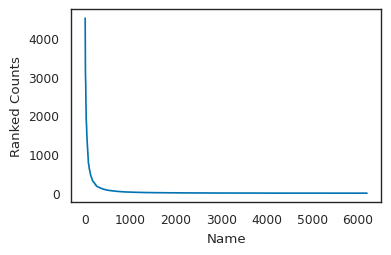

In [50]:
df_s = df.sort_values('Counts', ascending=False)

x = np.arange(len(df_s))
y = df_s.Counts.to_numpy()

plt.figure(figsize=fig_size)
sns.lineplot(x=x, y=y)
plt.xlabel('Name')
plt.ylabel('Ranked Counts')
plt.savefig('figures/name_counts.pdf')
plt.show()

# Create baby names 2021 population

In [51]:
names = []
counts = {}
for i, row in df.iterrows():
    names_i = [row['Names']] * int(row['Counts'])
    names += names_i
    counts[row['Names']] = row['Counts']


In [52]:
def name_sample(names, n=100):
    names_cp = copy.copy(names)
    rng = np.random.default_rng(seed=0)
    rng.shuffle(names_cp)
    names_i = rng.choice(names_cp, n)

    sample_data = {
        'Name': [],
        'Count': [],
        'Population Percentage': []
    }

    for name in names_i:
        sample_data['Name'].append(name)
        sample_data['Count'].append(counts[name])
        sample_data['Population Percentage'].append(counts[name] / len(names))


    df_sample = pd.DataFrame(data=sample_data)
    df_sample['Count'] = df_sample['Count'].astype('int')
    return df_sample

df_sample = name_sample(names, 100)
k = 5
top_k = df_sample.sort_values('Count').reset_index(drop=True)[:k]
top_k


,Name,Count,Population Percentage
0,Saahil,5,0.000017
1,Majed,5,0.000017
2,Anthony-James,5,0.000017
3,Nihan,8,0.000027
4,Rashid,12,0.000041


In [53]:
tex =  top_k.to_latex(
    index=False,
    float_format="{:.2E}".format,
    caption='Top 5 rarest names appearing in a random sample of UK baby names in 2021')
print(tex)

\begin{table}
\caption{Top 5 rarest names appearing in a random sample of UK baby names in 2021}
\begin{tabular}{lrr}
\toprule
Name & Count & Population Percentage \\
\midrule
Saahil & 5 & 1.69E-05 \\
Majed & 5 & 1.69E-05 \\
Anthony-James & 5 & 1.69E-05 \\
Nihan & 8 & 2.71E-05 \\
Rashid & 12 & 4.07E-05 \\
\bottomrule
\end{tabular}
\end{table}



# Failure rates of most common NER models on Huggingface

In [55]:
print(names[:10], len(names))
n = 10000

ner_models = [
    #'flair',
    'dslim/bert-base-NER',
    'dslim/bert-large-NER'
]

y_preds = []
test_names = []
models = []
acc = []

for model_name in ner_models:

    if 'flair' in model_name:
        
        y_pred_i = []

        df_sample = name_sample(names, n=n)

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):
            print('hi')
            sentence = Sentence(f"Good morning {name} how can i help you?")

            # load the NER tagger
            tagger = Classifier.load('ner-large')

            # run NER over sentence
            tagger.predict(sentence)

            # print the sentence with all annotations
            print(sentence)
            print(type(sentence))

    else:

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForTokenClassification.from_pretrained(model_name)

        y_pred_i = []

        df_sample = name_sample(names, n=n)

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):

            nlp = pipeline("ner", model=model, tokenizer=tokenizer)
            example = f"Good morning {name} how can i help you?"

            ner_results = nlp(example)

            # if no response
            if not ner_results:
                y_pred_i.append(0)
                continue

            # log 1 if a name was found.
            y_pred_j = 0
            for item in ner_results:
                # https://huggingface.co/dslim/bert-base-NER
                if item['entity'] in ['B-PER', 'I-PER', 'PER'] and item['index'] == 3:
                    y_pred_j = 1
            
            y_pred_i.append(y_pred_j)

    assert len(y_pred_i) == len(names_i)

    y_true = np.ones(len(names_i))
    acc_i = 1 - accuracy_score(y_true, y_pred_i)
    acc.append(acc_i)
    y_preds.append(y_pred_i)
    print(y_preds)
    test_names.append(names_i)
    models.append([model_name] * len(names_i))
    print(f'{model_name} Failure score {acc_i:.2f}')


df_ner = pd.DataFrame(data={
    'names': np.concatenate(test_names, axis=0),
    'y_pred': np.concatenate(y_preds, axis=0),
    'model': np.concatenate(models, axis=0)
})

df_ner.to_csv('data/ner_deep_learning_results.csv')

print(list(zip(ner_models, acc)))


['A', 'A', 'A', 'A', 'A', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay'] 295057


100%|██████████| 1994/1994 [04:01<00:00,  8.26it/s]


[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

100%|██████████| 1994/1994 [10:11<00:00,  3.26it/s]


[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
results_df = pd.read_csv('data/ner_deep_learning_results.csv')

mistakes = results_df[results_df['y_pred'] == 0]
mistakes

,Unnamed: 0,names,y_pred,model
26,26,Alfred,0,dslim/bert-base-NER
29,29,Amar,0,dslim/bert-base-NER
36,36,Aren,0,dslim/bert-base-NER
46,46,Aston,0,dslim/bert-base-NER
48,48,Atlas,0,dslim/bert-base-NER
73,73,Cairo,0,dslim/bert-base-NER
85,85,Charlie,0,dslim/bert-base-NER
92,92,Cj,0,dslim/bert-base-NER
101,101,Creed,0,dslim/bert-base-NER
110,110,Danish,0,dslim/bert-base-NER


In [ ]:
0.08*463

37.04